In [9]:
import dataclasses
import functools
import pathlib
import re
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tree
from loguru import logger

from analysis.data import (iter_experiment_folder, load_file_contents,
                           load_yaml, set_dtypes)
from analysis.metrics import assign_aois, FixationMapping

## Index all experiment data

In [10]:
from common import load_fixation_data, load_correctness_data


# fixations = load_fixation_data('../data/processed/fixations-new.parq')
fixations = pd.read_parquet("../data/processed/fixations-fixed.parq").reset_index()
correctness = load_correctness_data()

fixations_with_correctness = pd.merge(
    fixations,
    correctness,
    on=fixations.columns.intersection(correctness.columns).tolist(),
    how="inner",
)
annotations = load_yaml("../data/raw/annotations.yaml")
source_root = pathlib.Path("../data/raw/snippets")
source_index = {
    v["file"]: load_file_contents(source_root / v["file"])
    for k, v in annotations.items()
}

In [11]:
cfg = FixationMapping(time="plugin_time")
fixations_with_aois = assign_aois(
    fixations_with_correctness, annotations, source_index, cfg
)
fixations_with_aois[['pid', 'tid']].drop_duplicates()

sample = fixations_with_aois.query('pid == "p100" & tid == "t2"')
sample.head()

,pid,tid,fixation_id,left_pupil_diameter,right_pupil_diameter,x,y,gaze_target,position_interpolated,valid,...,start_time,end_time,duration,source_file_line,source_file_col,snippet,correct,aoi,aoi_size_in_lines,aoi_size_in_chars
0,p100,t2,0.0,17.302076,16.703319,473.583333,877.166667,rectangle-with-bug.cpp,13,0.458333,...,1.670446e+12,1.670446e+12,170.0,40,7,rectangle,False,target_function_lines,36.0,38.0
1,p100,t2,1.0,17.168025,16.607520,428.307692,891.461538,rectangle-with-bug.cpp,9,0.307692,...,1.670446e+12,1.670446e+12,107.0,41,4,rectangle,False,target_function_lines,36.0,38.0
2,p100,t2,2.0,16.856501,15.978247,671.210526,884.210526,rectangle-with-bug.cpp,7,0.631579,...,1.670446e+12,1.670446e+12,144.0,41,27,rectangle,False,target_function_lines,36.0,38.0
3,p100,t2,3.0,16.786908,15.083771,743.526316,842.052632,rectangle-with-bug.cpp,18,0.052632,...,1.670446e+12,1.670446e+12,140.0,40,33,rectangle,False,target_function_lines,36.0,38.0
4,p100,t2,4.0,15.836894,14.874761,628.777778,698.722222,rectangle-with-bug.cpp,9,0.500000,...,1.670446e+12,1.670446e+12,140.0,35,24,rectangle,False,testcase_comment_lines,12.0,13.0


## Exploration

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fixations_with_aois[['duration', 'n' ,'left_pupil_diameter', 'right_pupil_diameter']].describe()

# sns.displot(data=fixations_with_aois, x="duration", hue="snippet", )

,duration,n,left_pupil_diameter,right_pupil_diameter
count,75846.000000,75846.000000,75846.000000,75846.000000
mean,204.935039,25.322126,16.186096,16.111257
std,167.571966,20.160132,2.658617,2.494872
min,80.000000,3.000000,5.991911,6.748439
25%,110.000000,14.000000,14.429319,14.247132
50%,155.000000,19.000000,16.266432,16.205022
75%,235.000000,29.000000,18.001743,17.797208
max,3829.000000,481.000000,25.216125,37.067798


In [13]:
fixations_with_aois.query('duration > 1000')

,pid,tid,fixation_id,left_pupil_diameter,right_pupil_diameter,x,y,gaze_target,position_interpolated,valid,...,start_time,end_time,duration,source_file_line,source_file_col,snippet,correct,aoi,aoi_size_in_lines,aoi_size_in_chars
1061,p101,t3,186.0,18.432227,17.720461,519.773333,254.413333,rectangle-with-bug.cpp,100,0.333333,...,1.670454e+12,1.670454e+12,1173.0,13,14,rectangle,True,target_function_lines,36.0,38.0
1416,p101,t4,215.0,20.907716,21.292652,654.792208,277.175325,calculation-with-bug.cpp,99,0.357143,...,1.670455e+12,1.670455e+12,1231.0,6,27,calculation,True,target_function_lines,14.0,16.0
1725,p102,t3,22.0,20.331925,20.515444,627.413534,611.593985,calculation-with-bug.cpp,83,0.112782,...,1.670457e+12,1.670457e+12,1054.0,16,18,calculation,True,testcase_comment_lines,2.0,3.0
2060,p103,t1,111.0,16.852396,17.699946,624.122137,893.007634,number-checker-with-bug.cpp,59,0.549618,...,1.670459e+12,1.670459e+12,1050.0,40,26,number_checker,True,target_function_lines,33.0,35.0
3201,p103,t4,324.0,15.945262,16.433856,579.021583,393.258993,rectangle-with-bug.cpp,28,0.086331,...,1.670461e+12,1.670461e+12,1111.0,10,18,rectangle,False,target_function_lines,36.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75711,p99,t4,665.0,17.366821,17.663298,473.330357,391.919643,insertion-sort-with-bug.cpp,66,0.410714,...,1.670373e+12,1.670373e+12,1064.0,9,11,insertion_sort,True,target_function_lines,31.0,34.0
75801,p99,t4,762.0,18.287488,18.293094,630.698276,435.620690,insertion-sort-with-bug.cpp,68,0.413793,...,1.670373e+12,1.670373e+12,1105.0,16,28,insertion_sort,True,target_function_lines,31.0,34.0
75807,p99,t4,770.0,18.433437,18.535021,503.194595,478.600000,insertion-sort-with-bug.cpp,98,0.470270,...,1.670373e+12,1.670373e+12,1717.0,18,15,insertion_sort,True,target_function_lines,31.0,34.0
75813,p99,t4,779.0,16.415660,16.683285,570.450450,514.594595,insertion-sort-with-bug.cpp,40,0.639640,...,1.670373e+12,1.670373e+12,1076.0,18,19,insertion_sort,True,target_function_lines,31.0,34.0


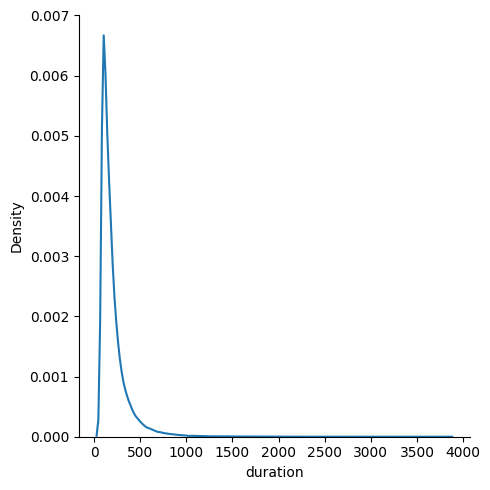

In [14]:
sns.displot(data=fixations_with_aois, x="duration", kind='kde')

### Fixation Counts by AOI

In [29]:
def compute_fixation_counts(df: pd.DataFrame, cfg: FixationMapping) -> pd.DataFrame:
    n_total_fixations = len(df)

    def _compute_fixation_count_per_aoi(df_slice: pd.DataFrame):
        nonlocal n_total_fixations
        n_fixations = len(df_slice)

        n_characters_in_aoi = df_slice.iloc[0][cfg.aoi_size_in_chars]

        return pd.Series(
            {
                cfg.aoi: df_slice.iloc[0][cfg.aoi],
                "total_fixation_count": n_fixations,
                "normalized_fixation_count": n_fixations / n_characters_in_aoi,
                "fixation_rate": n_fixations / n_total_fixations,
                "avg_fixation_duration": df_slice[cfg.fixation_duration].mean(),
                "ratio_of_on_target_fixation_duration": df_slice[
                    cfg.fixation_duration
                ].sum()
                / df[cfg.fixation_duration].sum(),
            }
        )

    return (
        df.groupby(cfg.aoi)
        .apply(_compute_fixation_count_per_aoi)
        .reset_index(drop=True)
    )


aoi_fixation_metrics = (
    fixations_with_aois.groupby(["pid", "tid", "snippet"])
    .apply(lambda df: compute_fixation_counts(df, cfg))
    # .reset_index(level=3, drop=True)
    # .reset_index()
)

# aoi_fixation_metrics.head()
fixations_with_aois
# aoi_fixation_metrics = pd.merge(
#     aoi_fixation_metrics, correctness, on=["pid", "tid", "snippet"]
# )
# aoi_fixation_metrics.pivot_table(
#     index=["snippet", "aoi"],
#     columns=["correct"],
#     values=[
#         "normalized_fixation_count",
#         "fixation_rate",
#         "avg_fixation_duration",
#         "ratio_of_on_target_fixation_duration",
#     ],
# )


/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_65768/3446264573.py:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(_compute_fixation_count_per_aoi)
/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_65768/3446264573.py:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


,pid,tid,fixation_id,left_pupil_diameter,right_pupil_diameter,x,y,gaze_target,position_interpolated,valid,...,start_time,end_time,duration,source_file_line,source_file_col,snippet,correct,aoi,aoi_size_in_lines,aoi_size_in_chars
0,p100,t2,0.0,17.302076,16.703319,473.583333,877.166667,rectangle-with-bug.cpp,13,0.458333,...,1.670446e+12,1.670446e+12,170.0,40,7,rectangle,False,target_function_lines,36.0,38.0
1,p100,t2,1.0,17.168025,16.607520,428.307692,891.461538,rectangle-with-bug.cpp,9,0.307692,...,1.670446e+12,1.670446e+12,107.0,41,4,rectangle,False,target_function_lines,36.0,38.0
2,p100,t2,2.0,16.856501,15.978247,671.210526,884.210526,rectangle-with-bug.cpp,7,0.631579,...,1.670446e+12,1.670446e+12,144.0,41,27,rectangle,False,target_function_lines,36.0,38.0
3,p100,t2,3.0,16.786908,15.083771,743.526316,842.052632,rectangle-with-bug.cpp,18,0.052632,...,1.670446e+12,1.670446e+12,140.0,40,33,rectangle,False,target_function_lines,36.0,38.0
4,p100,t2,4.0,15.836894,14.874761,628.777778,698.722222,rectangle-with-bug.cpp,9,0.500000,...,1.670446e+12,1.670446e+12,140.0,35,24,rectangle,False,testcase_comment_lines,12.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75841,p99,t4,810.0,16.495312,16.843663,625.380952,541.226190,insertion-sort-with-bug.cpp,46,0.452381,...,1.670373e+12,1.670373e+12,785.0,20,25,insertion_sort,True,target_function_lines,31.0,34.0
75842,p99,t4,811.0,15.760020,15.946660,700.860465,540.139535,insertion-sort-with-bug.cpp,23,0.465116,...,1.670373e+12,1.670373e+12,353.0,20,29,insertion_sort,True,target_function_lines,31.0,34.0
75843,p99,t4,812.0,16.490161,16.480105,651.703704,557.370370,insertion-sort-with-bug.cpp,18,0.333333,...,1.670373e+12,1.670373e+12,231.0,22,26,insertion_sort,True,target_function_lines,31.0,34.0
75844,p99,t4,813.0,16.661672,16.438751,435.333333,688.555556,insertion-sort-with-bug.cpp,14,0.222222,...,1.670373e+12,1.670373e+12,153.0,25,8,insertion_sort,True,target_function_lines,31.0,34.0


In [30]:
aoi_fixation_metrics[['total_fixation_count', 'normalized_fixation_count', 'fixation_rate']]

aoi  total_fixation_count  \
pid  tid snippet                                                          
p100 t2  rectangle      0                   other                   1.0   
                        1   target_function_lines                 187.0   
                        2  testcase_comment_lines                  18.0   
     t3  calculation    0                   other                  10.0   
                        1   target_function_lines                  82.0   
...                                           ...                   ...   
p99  t3  rectangle      0   target_function_lines                 176.0   
                        1  testcase_comment_lines                  24.0   
     t4  insertion_sort 0                   other                  66.0   
                        1   target_function_lines                 576.0   
                        2  testcase_comment_lines                 100.0   

                           normalized_fixation_count  fixation_rate  \
pid  tid snippet                                                      
p100 t2  rectangle      0                   0.001610       0.004854   
                        1                   4.921053       0.907767   
                        2                   1.384615       0.087379   
     t3  calculation    0                   0.027473       0.091743   
                        1                   5.125000       0.752294   
...                                              ...            ...   
p99  t3  rectangle      0                   4.631579       0.880000   
                        1                   1.846154       0.120000   
     t4  insertion_sort 0                   0.072527       0.088949   
                        1                  16.941176       0.776280   
                        2                  33.333333       0.134771   

                           avg_fixation_duration  \
pid  tid snippet                                   
p100 t2  rectangle      0             318.000000   
                        1             154.786096   
                        2             123.666667   
     t3  calculation    0             148.400000   
                        1             128.060976   
...                                          ...   
p99  t3  rectangle      0             395.710227   
                        1             321.041667   
     t4  insertion_sort 0             319.257576   
                        1             390.569444   
                        2             416.330000   

                           ratio_of_on_target_fixation_duration  pid  tid  \
pid  tid snippet                                                            
p100 t2  rectangle      0                              0.010099  NaN  NaN   
                        1                              0.919210  NaN  NaN   
                        2                              0.070691  NaN  NaN   
     t3  calculation    0                              0.108758  NaN  NaN   
                        1                              0.769586  NaN  NaN   
...                                                         ...  ...  ...   
p99  t3  rectangle      0                              0.900388  NaN  NaN   
                        1                              0.099612  NaN  NaN   
     t4  insertion_sort 0                              0.073247  NaN  NaN   
                        1                              0.782030  NaN  NaN   
                        2                              0.144724  NaN  NaN   

                           fixation_id  left_pupil_diameter  ...   n  \
pid  tid snippet                                             ...       
p100 t2  rectangle      0          NaN                  NaN  ... NaN   
                        1          NaN                  NaN  ... NaN   
                        2          NaN                  NaN  ... NaN   
     t3  calculation    0          NaN                  NaN  ... NaN   
                        1          

rectangle


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.035714,0.000000
target_function_lines,0.035714,0.000000,0.464286
testcase_comment_lines,0.000000,0.464286,0.000000


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.056338,0.000000
target_function_lines,0.056338,0.000000,0.443662
testcase_comment_lines,0.000000,0.443662,0.000000


calculation


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.169096,0.008746
target_function_lines,0.163265,0.000000,0.323615
testcase_comment_lines,0.014577,0.320700,0.000000


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.139175,0.015464
target_function_lines,0.149485,0.000000,0.340206
testcase_comment_lines,0.005155,0.350515,0.000000


insertion_sort


,other,target_function_lines,testcase_comment_lines
other,0.00000,0.303922,0.003268
target_function_lines,0.30719,0.000000,0.192810
testcase_comment_lines,0.00000,0.192810,0.000000


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.278195,0.007519
target_function_lines,0.280702,0.000000,0.213033
testcase_comment_lines,0.005013,0.215539,0.000000


number_checker


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.098655,0.004484
target_function_lines,0.103139,0.000000,0.394619
testcase_comment_lines,0.000000,0.399103,0.000000


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.071429,0.000000
target_function_lines,0.071429,0.000000,0.428571
testcase_comment_lines,0.000000,0.428571,0.000000


money_class


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.039216,0.074510
target_function_lines,0.054902,0.000000,0.376471
testcase_comment_lines,0.058824,0.396078,0.000000


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.033708,0.078652
target_function_lines,0.022472,0.000000,0.393258
testcase_comment_lines,0.089888,0.382022,0.000000


graph_utils


,docstring_lines,other,target_function_lines,testcase_comment_lines
docstring_lines,0.000000,0.002304,0.218894,0.076037
other,0.011521,0.000000,0.052995,0.039171
target_function_lines,0.218894,0.066820,0.000000,0.099078
testcase_comment_lines,0.064516,0.034562,0.115207,0.000000


,docstring_lines,other,target_function_lines,testcase_comment_lines
docstring_lines,0.000000,0.006178,0.218533,0.080309
other,0.013127,0.000000,0.061004,0.034749
target_function_lines,0.210039,0.070270,0.000000,0.094981
testcase_comment_lines,0.082625,0.032432,0.095753,0.000000


distance


,NaN
NaN,1.0


""


numbers_hrn


,docstring_lines,other,target_function_lines,testcase_comment_lines
docstring_lines,0.000000,0.003976,0.130219,0.083499
other,0.005964,0.000000,0.097416,0.020875
target_function_lines,0.166998,0.102386,0.000000,0.142147
testcase_comment_lines,0.043738,0.017893,0.184891,0.000000


,docstring_lines,other,target_function_lines,testcase_comment_lines
docstring_lines,0.000000,0.001739,0.142609,0.090435
other,0.001739,0.000000,0.081739,0.010435
target_function_lines,0.187826,0.083478,0.000000,0.149565
testcase_comment_lines,0.045217,0.008696,0.196522,0.000000


numbers_hrd


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.037915,0.028436
target_function_lines,0.042654,0.000000,0.431280
testcase_comment_lines,0.023697,0.436019,0.000000


,other,target_function_lines,testcase_comment_lines
other,0.000000,0.048780,0.048780
target_function_lines,0.060976,0.000000,0.396341
testcase_comment_lines,0.036585,0.408537,0.000000


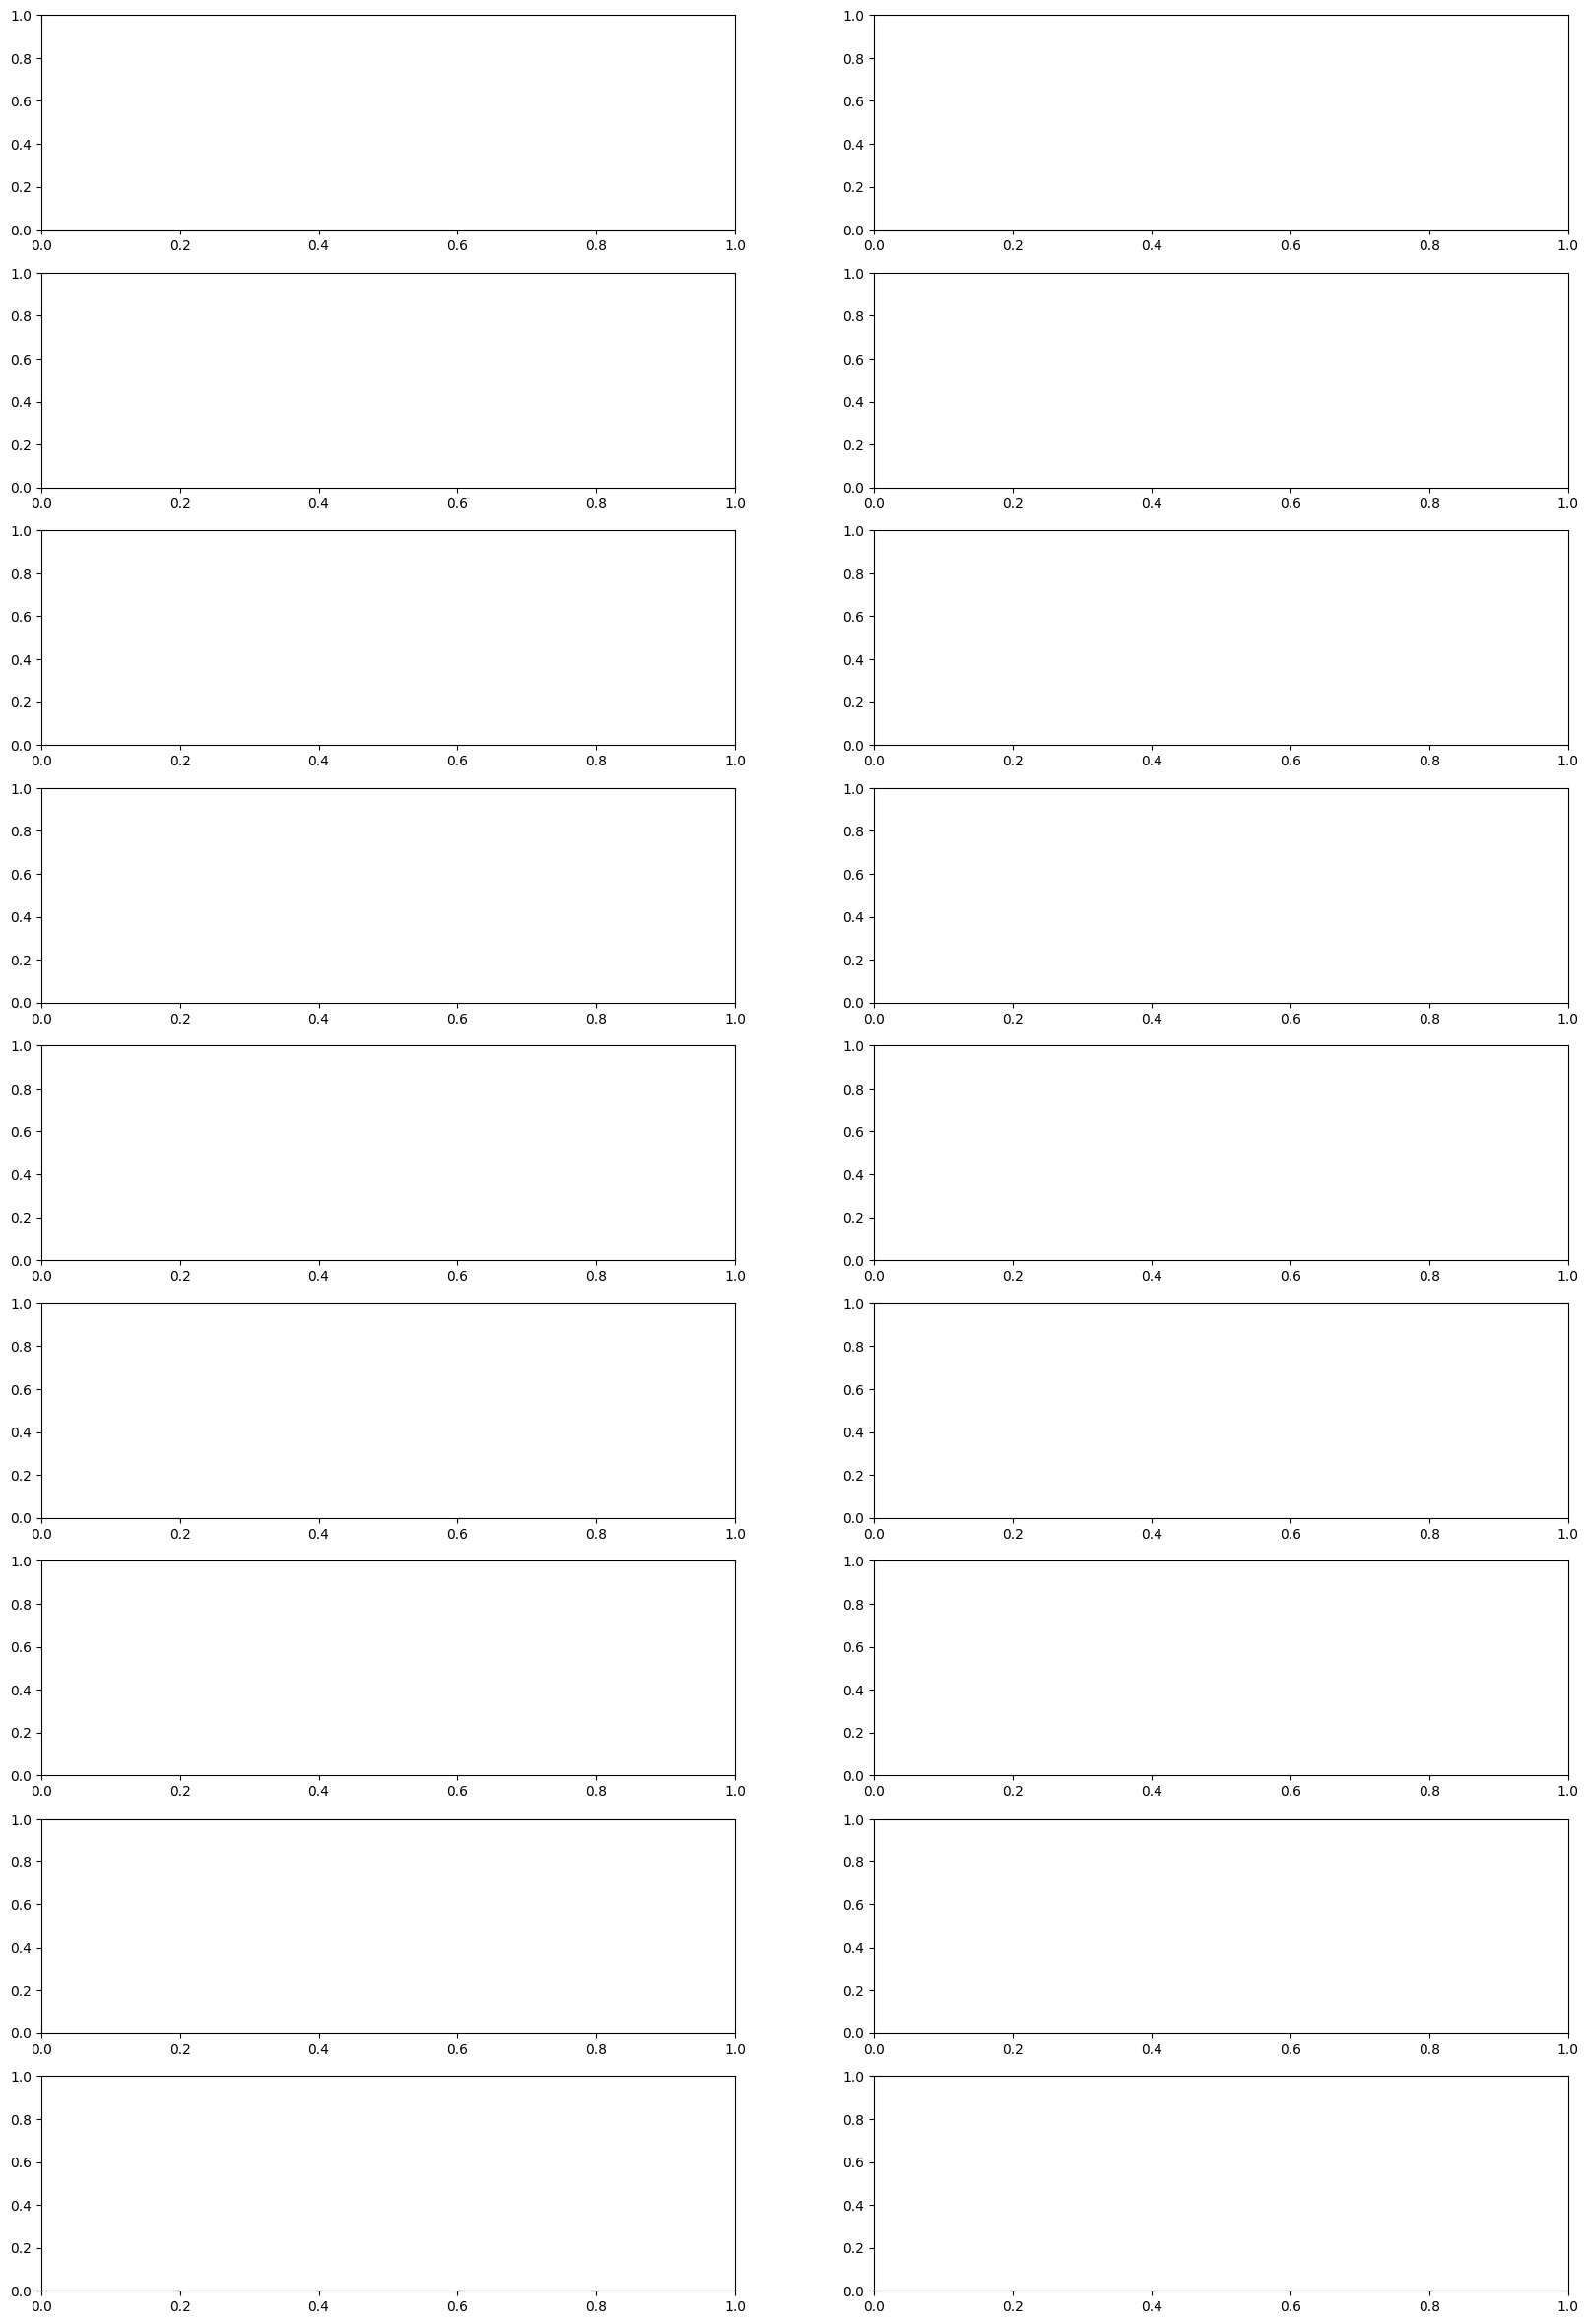

In [35]:
def drop_consequtive_duplicates(seq):
    sentinel = object()
    last_item = sentinel 
    results = []
    for item in seq:
        if item == last_item:
            continue
        results.append(item)
        last_item = item
    return results 


def compute_aoi_transitions(df: pd.DataFrame, cfg: FixationMapping) -> pd.DataFrame:

    aoi_sequence = df[cfg.aoi].values
    aoi_sequence = drop_consequtive_duplicates(aoi_sequence)
    all_aois = df[cfg.aoi].unique().tolist()
    all_aois = sorted(all_aois)
    n_aois = len(all_aois)
    transitions = pd.DataFrame(data=np.zeros((n_aois, n_aois)), columns=all_aois, index=all_aois)

    for prev, curr in zip(aoi_sequence[:-1], aoi_sequence[1:]):
        transitions.at[prev, curr] += 1
    n_transitions_total = (len(aoi_sequence) - 1)
    return transitions / n_transitions_total

# Draw transitions
all_snippets = fixations_with_aois.snippet.unique().tolist()
from IPython.display import display
fix, axes = plt.subplots(len(all_snippets), 2, figsize=(20, 30))
for i, snippet in enumerate(all_snippets):
    subset_df = fixations_with_aois.query('snippet == @snippet')
    correct = subset_df.query('correct == True')
    incorrect = subset_df.query('correct == False')
    a = compute_aoi_transitions(correct, cfg)
    b = compute_aoi_transitions(incorrect, cfg)
    print(snippet)
    display(a)
    display(b)
    # axes[i][0].set_title(f"{snippet=}, correct=True")
    # sns.heatmap(data=compute_aoi_transitions(correct, cfg), ax=axes[i][0])
    # axes[i][1].set_title(f"{snippet=}, Incorrect")
    # sns.heatmap(data=compute_aoi_transitions(incorrect, cfg), ax=axes[i][1])

## Pupil Diameter Metrics

### By AOI

In [336]:
d = fixations_with_aois.groupby(['correct', cfg.aoi])[cfg.left_pupil_diameter].mean().reset_index()
d.pivot_table(index='aoi', columns='correct', )

left_pupil_diameter           
correct                              False      True 
aoi                                                  
docstring_lines                  16.443437  16.631214
other                            15.946609  17.005061
target_function_lines            15.935348  16.337488
testcase_comment_lines           16.269436  16.414351

In [337]:
d = fixations_with_aois.groupby(['correct', cfg.aoi])[cfg.right_pupil_diameter].mean().reset_index()
d.pivot_table(index='aoi', columns='correct', )

right_pupil_diameter           
correct                               False      True 
aoi                                                   
docstring_lines                   16.067749  16.300469
other                             15.766757  16.994665
target_function_lines             15.660268  16.408970
testcase_comment_lines            16.091006  16.452826

## Matrix Profile

In [338]:
import stumpy
from matplotlib.patches import Rectangle

subset_df = fixations_with_aois.query('snippet == "numbers_hrd"')
grouper = subset_df.groupby(["pid", "tid"])

fixation_sequences = [
    grouper.get_group(g)[cfg.line].astype(float) for g in grouper.groups
]

<Axes: >

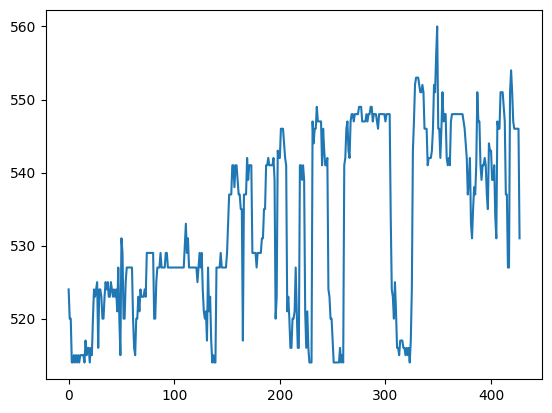

In [339]:
sns.lineplot(fixation_sequences[0].values)

In [340]:
m = 20
mp = stumpy.stump(fixation_sequences[0].values, m=m)
motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The motif is located at index 316
The nearest neighbor is located at index 251


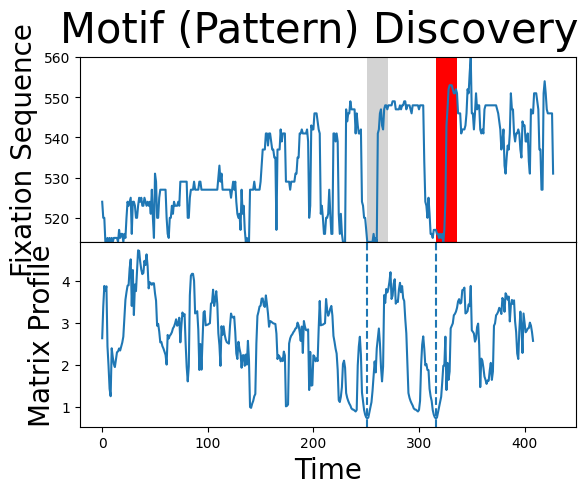

In [341]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(fixation_sequences[0].values)
axs[0].set_ylim(fixation_sequences[0].min(), fixation_sequences[0].max())
axs[0].set_ylabel('Fixation Sequence', fontsize='20')
rect = Rectangle((motif_idx, 0), m, 4_000, facecolor='red')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 4_000, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()


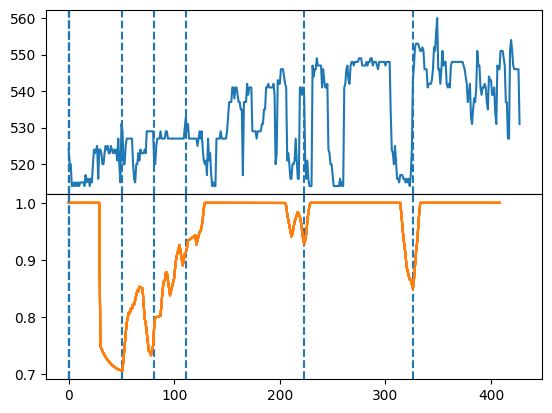

[ 51  81 326 111 223   0   0   0   0]


In [342]:
L = 30
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=10, excl_factor=1)

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(range(fixation_sequences[0].shape[0]), fixation_sequences[0].values)
for regime_location in regime_locations:
    axs[0].axvline(x=regime_location, linestyle="dashed")
    axs[1].plot(range(cac.shape[0]), cac, color='C1')
    axs[1].axvline(x=regime_location, linestyle="dashed")
plt.show()

print(regime_locations)

### Combined

In [343]:
def combine_sequences(sequences):
    items = []
    for sequence in sequences:
        items.extend(sequence)
        items.append(np.nan)
    return np.array(items)

combined = combine_sequences(fixation_sequences)

m = 20
mp = stumpy.stump(combined, m=m)
motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The motif is located at index 3410
The nearest neighbor is located at index 3800


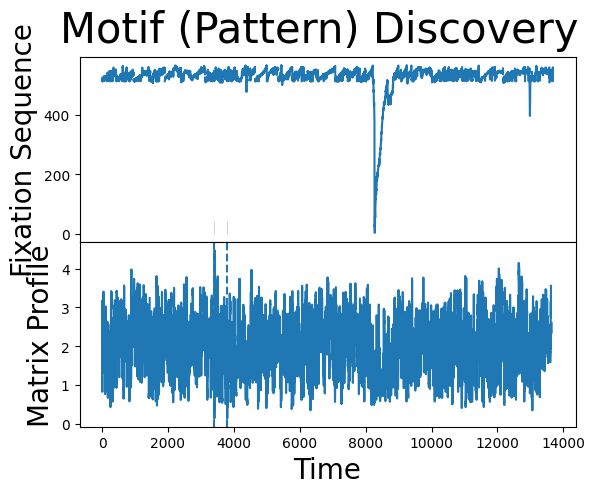

In [207]:
def draw_motif_discovery_graph(sequence, motif_idx, nearest_neighbor_idx):
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

    axs[0].plot(sequence)
    axs[0].set_ylabel('Fixation Sequence', fontsize='20')
    rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='20')
    axs[1].set_ylabel('Matrix Profile', fontsize='20')
    axs[1].axvline(x=motif_idx, linestyle="dashed")
    axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
    axs[1].plot(mp[:, 0])
    plt.show()

draw_motif_discovery_graph(combined, motif_idx, nearest_neighbor_idx)

In [210]:
for motif_idx in np.argsort(mp[:, 0])[:10]:
    motif_sequence = combined[motif_idx: motif_idx + m]
    seq = drop_consequtive_duplicates(motif_sequence.astype(int))
    print([item + 1 for item in seq])

[549, 521, 549]
[548, 549, 517, 549]
[544, 549, 521, 549]
[545, 548, 549, 517, 549]
[516, 547, 517, 516, 515, 516, 517, 516, 515, 543, 542, 543, 544]
[528, 530, 528, 530]
[528, 530, 528, 530]
[515, 516, 547, 517, 516, 515, 516, 517, 516, 515, 543, 542, 543]
[561, 562, 563, 562, 563, 562, 563, 530]
[549, 548]


NameError: name 'snippet' is not defined

## Graph Transitions

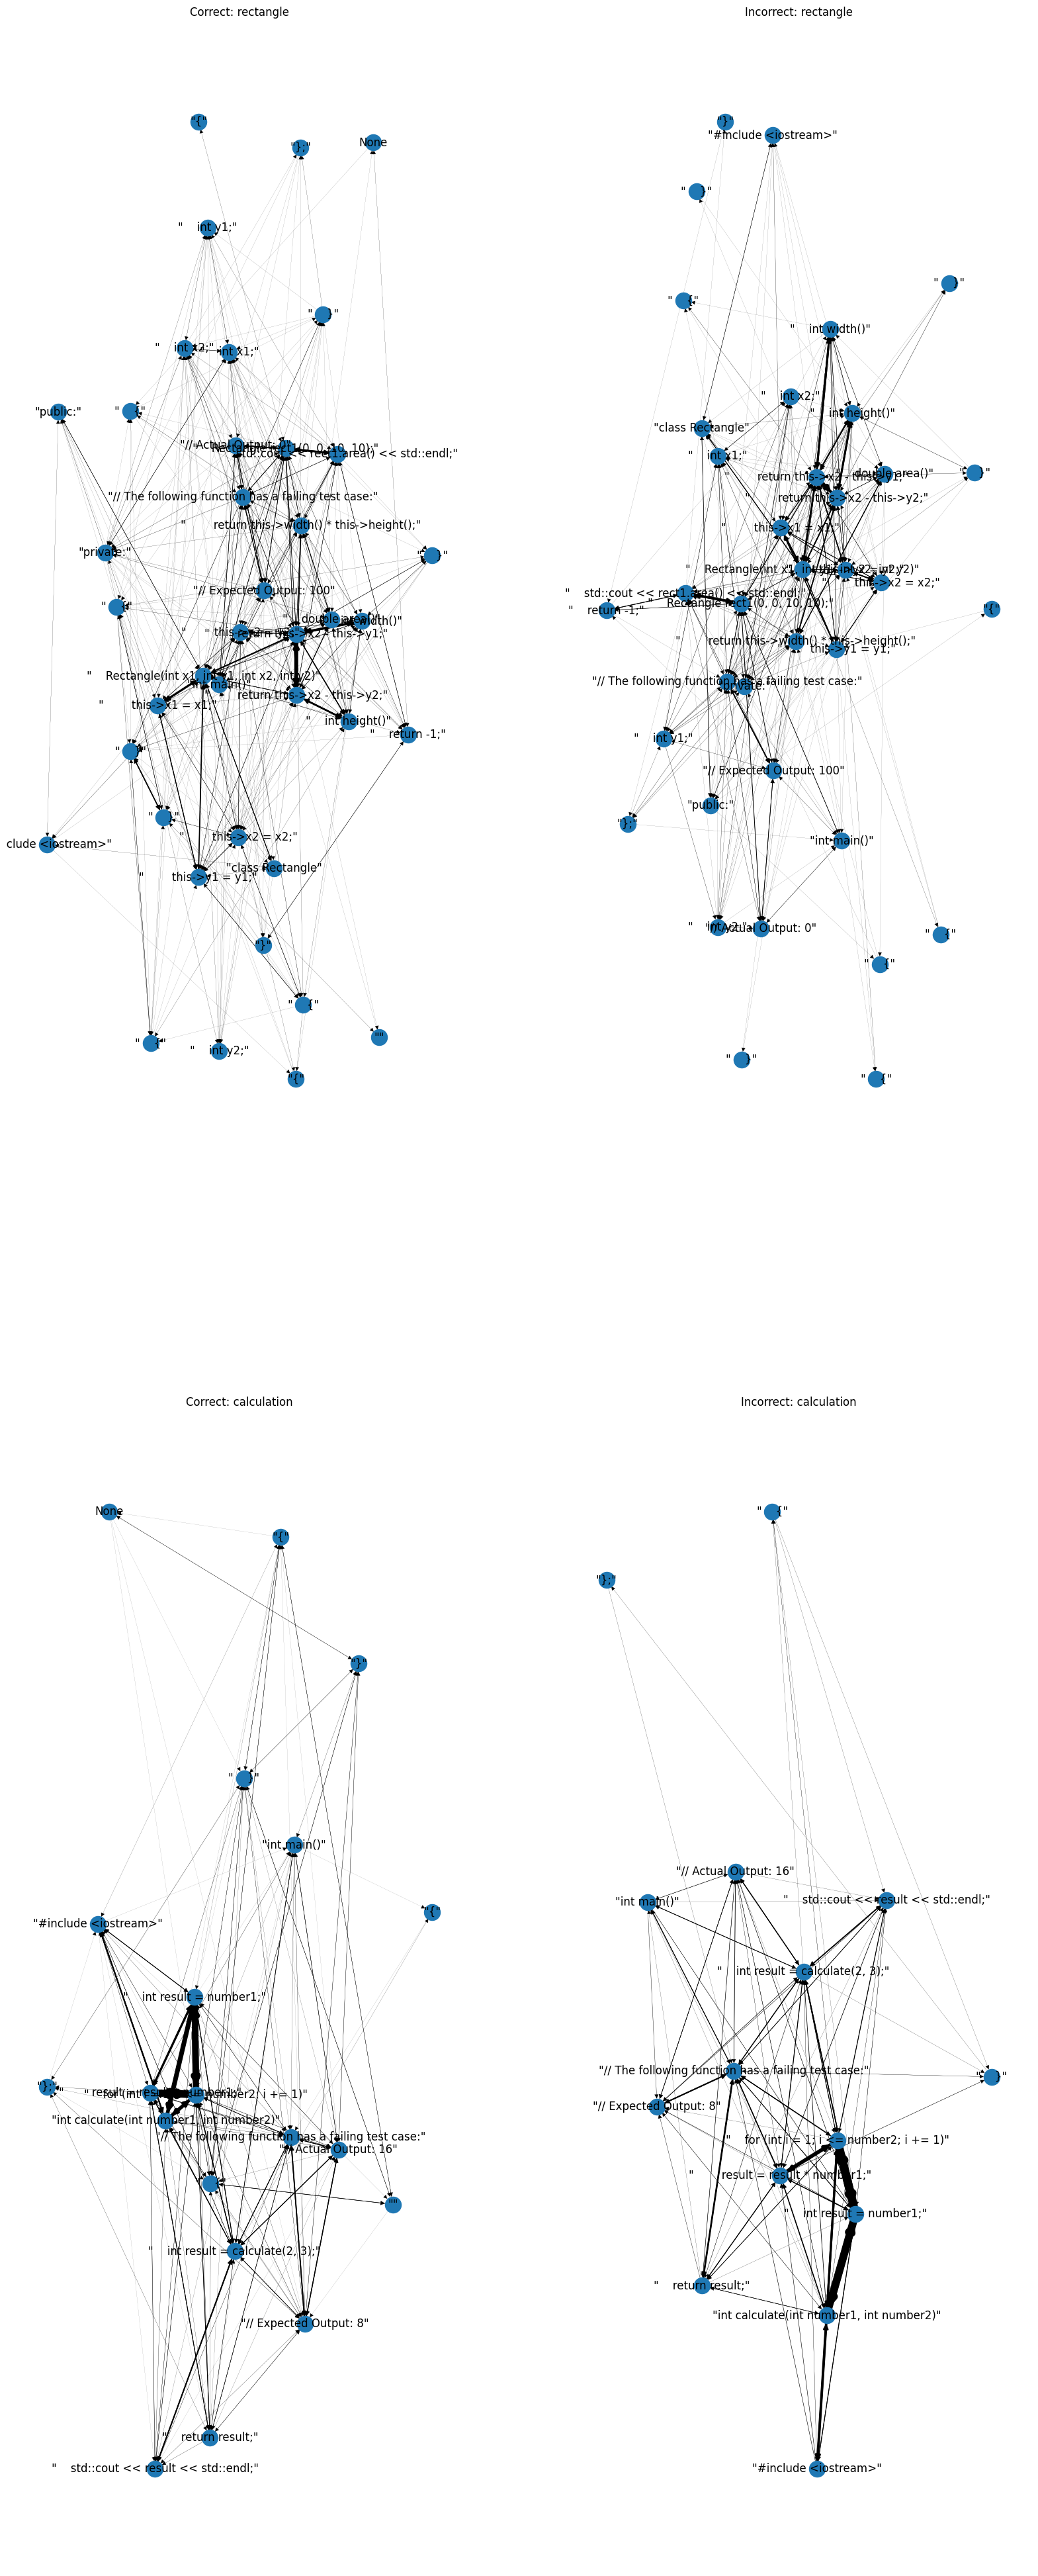

In [328]:
import networkx as nx
import collections

def compute_transition_graph(df: pd.DataFrame):
    lines = df[cfg.line].values
    lines = drop_consequtive_duplicates(lines)
    lines = [line + 1 for line in lines]
    g = nx.DiGraph()
    total = 0
    for prev, curr in zip(lines, lines[1:]):
        total += 1
        if g.has_edge(prev, curr):
            g[prev][curr]['weight'] += 1
        else:
            g.add_edge(prev, curr, weight=1)
            
    for edge in g.edges:
        g.edges[edge]['weight'] /= total

    return g

def compute_linear_positions(g, line_height=30):
    nodes = list(g.nodes)
    nodes = sorted(nodes)
    pos = {}
    n_lines = len(nodes)
    for i, node in enumerate(nodes):
        y_pos = i * line_height 
        pos[node] = (i, (n_lines * line_height) - y_pos)
    return pos

def draw_transition_freqs(g, cutoff=0.5, source=None, **kwargs):
    labels = {i+1: f'\"{line}\"' for i, line in enumerate(source.splitlines())}
    q = np.quantile(
        list(nx.get_edge_attributes(g, 'weight').values()),
        cutoff
    )
    all_edges = list(g.edges(data=True))
    for source, target, attrs in all_edges:
        if attrs['weight'] < q:
            g.remove_edge(source, target)
    all_nodes = list(g.nodes)
    for node in all_nodes:
        if g.degree(node) == 0:
            g.remove_node(node)
    for node in g.nodes:
        g.nodes[node]['label'] = labels.get(node)
    
    # pos = nx.nx_pydot.graphviz_layout(g, )
    SCALE = 100
    edge_weights = [SCALE * w for w in nx.get_edge_attributes(g, 'weight').values()]
    labels = nx.get_node_attributes(g, 'label')
    pos = compute_linear_positions(g)
    nx.draw(g, width=edge_weights,  with_labels=True, labels=labels,**kwargs)

all_snippets = fixations_with_aois.snippet.unique().tolist()[:2]
graphs_by_snippet = collections.defaultdict(dict)

for i, snippet in enumerate(all_snippets):
    subset_df = fixations_with_aois.query('snippet == @snippet')
    correct = subset_df.query('correct == True')
    incorrect = subset_df.query('correct == False')
    graphs_by_snippet[snippet]['correct'] = compute_transition_graph(correct)
    graphs_by_snippet[snippet]['incorrect'] = compute_transition_graph(incorrect)

cutoff = 0.20
fig, axes = plt.subplots(len(all_snippets), 2, figsize=(20, 50))
for i, snippet in enumerate(all_snippets):
    source = source_index[annotations[snippet]['file']]

    correct = graphs_by_snippet[snippet]['correct'].copy()
    axes[i, 0].set_title(f'Correct: {snippet}')
    draw_transition_freqs(correct, cutoff=cutoff, source=source, ax=axes[i, 0])
    incorrect = graphs_by_snippet[snippet]['incorrect'].copy()
    axes[i, 1].set_title(f'Incorrect: {snippet}')
    draw_transition_freqs(incorrect, cutoff=cutoff, source=source, ax=axes[i, 1])

    

In [322]:


source = source_index['numbers_c.cc']
g = graphs_by_snippet['numbers_hrn']['correct']
draw_transition_freqs(g, cutoff=0.9, source=source )

KeyError: 'correct'

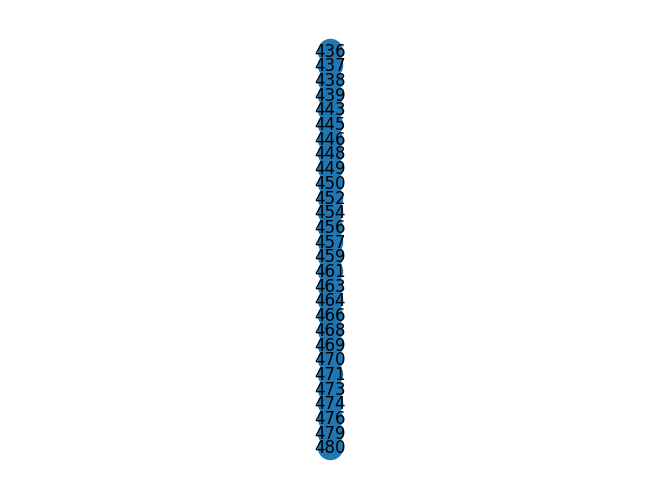

In [316]:
g = nx.DiGraph()
g.add_edge(1, 2)
g.add_edge(4, 5)

g = graphs_by_snippet['numbers_hrn']['correct']
nx.draw(g, pos=compute_linear_positions(g), with_labels=True)